### 0 - Imports

In [1]:
from warnings import simplefilter
from statsmodels.tools.sm_exceptions import ConvergenceWarning
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ConvergenceWarning)
simplefilter(action='ignore', category=UserWarning)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.size'] = 10
plt.rcParams.update({
    # 'text.usetex': True,
    'font.family': 'serif',
})

# Custom scripts
from scripts.dataset_io import getDatasetFilePath, getDataset

### 1 - Globals

In [2]:
dataDir: str = '../data'
countryName: str = 'Portugal'

settings: 'dict[str, any]' = {
	'filePath': getDatasetFilePath(
		dataDir, 
		countryName, 
		fallback='CPITimeSeries'
	),
	'countryName': countryName,
	'indicator': 'PCPI_IX',
}

In [141]:
def tsPlot(tsList, title, xlabel, ylabel, legend = None, rotateLabels = False) -> None:
	for ts in tsList:
		plt.plot(ts)
	if legend: plt.legend(legend)
	plt.title(title)
	plt.ylabel(ylabel)
	plt.xlabel(xlabel)
	if(rotateLabels): plt.xticks(rotation=90)
	plt.show()

### 2 - Extract relevant info + Data Understanding

In [4]:
def understandData(df: pd.DataFrame) -> None :
  print('DATAFRAME INFO')
  print('------')
  print('df shape:', df.shape)
  print('------')
  print('df head: \n', df.head())
  print('------')
  print('df dtypes:\n', df.dtypes)
  print('------')
  print('df describe: \n', df.describe())
  print('------')
  print('df info: \n', df.info())

In [5]:
df: pd.DataFrame = getDataset(dataDir, settings)

Reading from ../data/Portugal.pkl ...
Done!


In [6]:
understandData(df)

DATAFRAME INFO
------
df shape: (392, 3)
------
df head: 
          cpi  year  month
0  42.431999  1990      1
1  43.377998  1990      2
2  43.632000  1990      3
3  44.134998  1990      4
4  44.603001  1990      5
------
df dtypes:
 cpi      float32
year       int16
month       int8
dtype: object
------
df describe: 
               cpi         year       month
count  392.000000   392.000000  392.000000
mean    84.125526  2005.836735    6.459184
std     17.846661     9.443539    3.448320
min     42.431999  1990.000000    1.000000
25%     69.122252  1998.000000    3.000000
50%     88.884003  2006.000000    6.000000
75%    100.434250  2014.000000    9.000000
max    114.554001  2022.000000   12.000000
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpi     392 non-null    float32
 1   year    392 non-null    int16  
 2   month   392 non-null    int8

In [7]:
def dfToSeries(df):
	ts: np.ndarray = df['cpi'].to_numpy()
	ts: pd.Series = pd.Series(
		ts, 
		index=pd.date_range('1-1-1990', periods=len(ts), freq='M'),
		name='CPI'
	)
	return ts

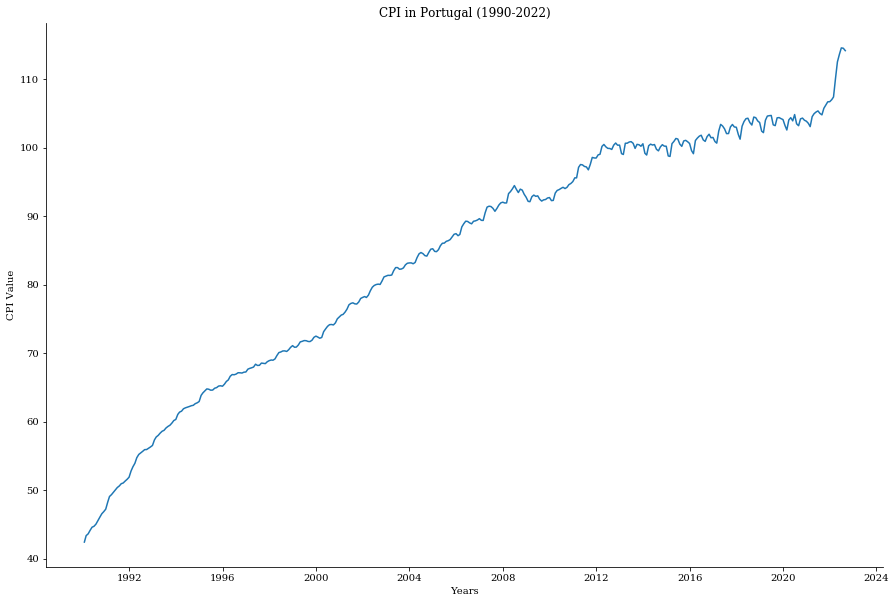

In [8]:
# Convert DataFrame to Time Series
ts: np.ndarray = df['cpi'].to_numpy()
ts: pd.Series = pd.Series(
	ts, 
	index=pd.date_range('1-1-1990', periods=len(ts), freq='M'),
	name='CPI'
)

tsPlot(
	[ts],
	title='CPI in Portugal (1990-2022)', 
	xlabel='Years', 
	ylabel='CPI Value'
)

### 3 - Data Splitting

In [9]:
# Split data - a 60%-40% split (mostly random values, 
# but we wanted to fit the model using old and more recent 
# data that included data after the Global Financial Crisis of 2008)
def splitDataset(ts, trainSize = 0.60) -> 'tuple(pd.Series, pd.Series)':
	cutoffPoint: int = round(trainSize * len(ts))
	return (ts[:cutoffPoint], ts[cutoffPoint:])

In [10]:
tsTrain, tsTest = splitDataset(ts[:'2021'])

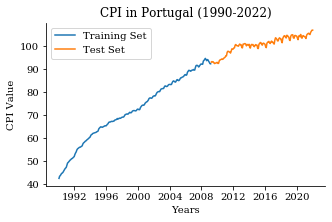

In [11]:
plt.rcParams['figure.figsize'] = (5, 3)

tsPlot(
	[tsTrain, tsTest], 
	title='CPI in Portugal (1990-2022)', 
	xlabel='Years', 
	ylabel='CPI Value',
	legend=['Training Set', 'Test Set']
)

### 4 - Basic Description Techniques & Transformations

At first glance, the plots suggest a multiplicative 
model fits the data better, i.e

$\\x(n)=tr(n)sn(n)e(n).$

We can see the seasonality and erratic components changing 
(in our case, increasing) with the trend. We expect a more
stable plot upon detrending the TS, when assuming a
multiplicative model (compared to an additive one).

#### 4.1 - Trend

In [12]:
def calculateMSE(ts: pd.Series, fittedTs: pd.Series) -> float:
	absError: pd.Series = fittedTs - ts
	return np.mean(np.square(absError))


##### I - Polinomial Fitting

In [13]:
x = np.arange(len(tsTrain))

In [14]:
# Assuming a linear trend
linearCoefs = np.polyfit(x, tsTrain, 1)
linearValues = np.polyval(linearCoefs, x)
linearTs = pd.Series(
	data=linearValues,
	index=tsTrain.index
)

In [15]:
# Assuming a quadratic trend
quadCoefs = np.polyfit(x, tsTrain, 2)
quadValues = np.polyval(quadCoefs, x)
quadTs = pd.Series(
	data=quadValues,
	index=tsTrain.index
)

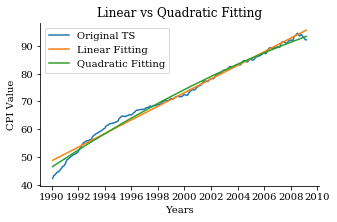

In [16]:
tsPlot(
	[tsTrain, linearTs, quadTs], 
	title='Linear vs Quadratic Fitting',
	xlabel='Years',
	ylabel='CPI Value',
	legend=['Original TS', 'Linear Fitting', 'Quadratic Fitting']
)

##### Additive vs Multiplicative

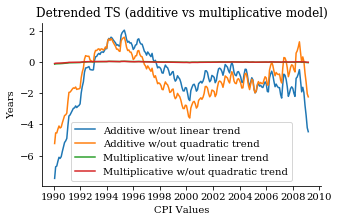

In [17]:
plt.rcParams['figure.figsize'] = (5, 3)

# Removing trends
linearTsDetrendedAdd = tsTrain - linearTs
quadTsDetrendedAdd = tsTrain - quadTs

# Removing polinomial trends
linearTsDetrendedMult = tsTrain/linearTs
quadTsDetrendedMult = tsTrain/quadTs

tsPlot(
	[linearTsDetrendedAdd - 1, quadTsDetrendedAdd - 1,
	linearTsDetrendedMult - 1, quadTsDetrendedMult - 1],
	title='Detrended TS (additive vs multiplicative model)',
	xlabel='CPI Values',
	ylabel='Years',
	legend=[
		'Additive w/out linear trend', 
		'Additive w/out quadratic trend',
		'Multiplicative w/out linear trend', 
		'Multiplicative w/out quadratic trend',
	]
)

##### II - Moving Average

In [18]:
# 'm': number of samples used
# to calculate the average
# for each window
def maFiltering(ts, m, dataAug = True) -> pd.Series:
	w = np.ones(m) * (1 / float(m))
	lag: int = int(np.floor((m - 1) / 2))
	if dataAug:
		# Artificially add data to compensate
		# for the samples lost in the calculation
		# of the mean with a window of M samples
		tsAug = np.flip(ts[:lag]) \
			.append(ts.append(np.flip(ts[-lag:])))
	else: tsAug = ts

	nf: range = range(lag, tsAug.size - lag)
	xf = np.zeros(tsAug.size - 2 * lag).astype('float')

	for n in nf:
		xf[n - lag] = (1 / float(sum(w))) * np.sum(np.multiply(tsAug[n - lag: n + lag + 1], w))

	return pd.Series(
		data=xf, 
		index=tsAug.index[lag: tsAug.size - lag]
	)

In [19]:
mValues: 'list[int]' = [7, 13]
maSeries: 'list[pd.Series]' = [ maFiltering(tsTrain, m) for m in mValues ]
maLegend: 'list[str]' = [ f'MA w/ M = {m}' for m in mValues ]

In [20]:
# Detrend TS with M = 13 and with M = 7
maTs7: pd.Series = maSeries[0]
maTs13: pd.Series = maSeries[1]
maTsDetrended13 = tsTrain/maTs13
maTsDetrended7 = tsTrain/maTs7

##### III - LOWESS

In [21]:
import statsmodels.api as sm
from scipy.optimize import curve_fit

In [22]:
def linearFunction(x, a, b):
	return a * x + b

def xWeights(x, xi, span):
    return (1 - abs((x - xi) / float(span)) ** 3) ** 3

def yWeights(ri, MAD):
  if np.abs(ri) >= 6 * MAD:  return 0
  return (1 - ((ri / (6 * MAD)) ** 2)) ** 2

def loessPass(ts, span, tsE=pd.Series(np.array([])), timePass=True):
    lag= int((span - 1) / 2)
    xf= np.zeros(ts.size).astype('float')
    for k in range(ts.size):
        if k <= lag:
            win= ts[0: span]
            if not timePass:
                winE= tsE[0: span]
            xvs = np.array(range(span))
        elif k>ts.size-lag:
            win= ts[ts.size-span: ts.size]
            if not timePass:
                winE= tsE[tsE.size - span: tsE.size]
            xvs= np.array(range(ts.size - span, ts.size))
        else:
            win=ts[k-lag-1:k+lag]
            if not timePass:
                winE= tsE[k - lag - 1: k + lag]
            xvs= np.array(range(k-lag, k + lag + 1))

        ws= np.zeros(span).astype('float')
            
        if not timePass:
            res= np.array(win-winE)
            MAD= np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(
                    k, xvs[xw], 
                    np.max(
                        (np.abs(k-xvs[0]),
                        np.abs(k-xvs[-1]))
                    )
                )
            else:
                ws[xw] = yWeights(res[xw], MAD)
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k] = res_wls.params[1] * k + res_wls.params[0]
    return xf

def lowess(ts, span, ftype='linear'):
    xf= loessPass(ts, span=span, timePass=True)
    xf= loessPass(ts, tsE=pd.Series(data=xf, index=ts.index), span=span, timePass=False)
    xf= pd.Series(data=xf, index=ts.index)
    return xf

In [23]:
lowessSeries: 'list[pd.Series]' = [ lowess(tsTrain, span=m) for m in mValues ]
lowessLegend: 'list[str]' = [ f'LOWESS w/ M = {m}' for m in mValues ]

In [24]:
# Detrend TS with M = 13 and with M = 7
lowessTs7: pd.Series = lowessSeries[0]
lowessTs13: pd.Series = lowessSeries[1]
lowessTsDetrended13 = tsTrain/lowessTs13
lowessTsDetrended7 = tsTrain/lowessTs7

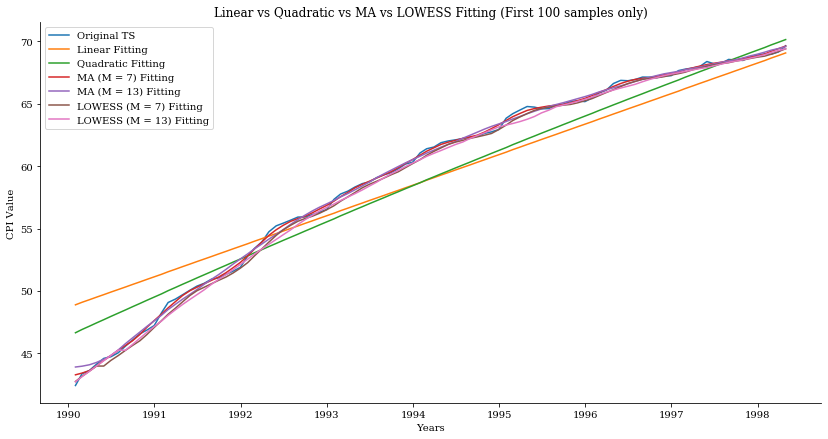

In [25]:
plt.rcParams['figure.figsize'] = (14, 7)

tsPlot(
	[
		tsTrain[:100], 
		linearTs[:100], 
		quadTs[:100], 
		maTs7[:100], 
		maTs13[:100], 
		lowessTs7[:100], 
		lowessTs13[:100]
	], 
	title='Linear vs Quadratic vs MA vs LOWESS Fitting (First 100 samples only)',
	xlabel='Years',
	ylabel='CPI Value',
	legend=[
		'Original TS', 
		'Linear Fitting', 
		'Quadratic Fitting',
		'MA (M = 7) Fitting',
		'MA (M = 13) Fitting',
		'LOWESS (M = 7) Fitting',
		'LOWESS (M = 13) Fitting',
	]
)

With the plot above, we can see that the smoothing based approaches fit the data much better. With that said, we will discard linear and quadratic fitting.

If we look at the raw time series plot, we can detect a big cycle that has a periodicity of about a year. Through a more careful observation, however, we can identify another (shorter) pattern, with a periodicity of ~6 months, albeit more unstable.
So it is logical to detrend the TS based on these assumptions and compare both of them.

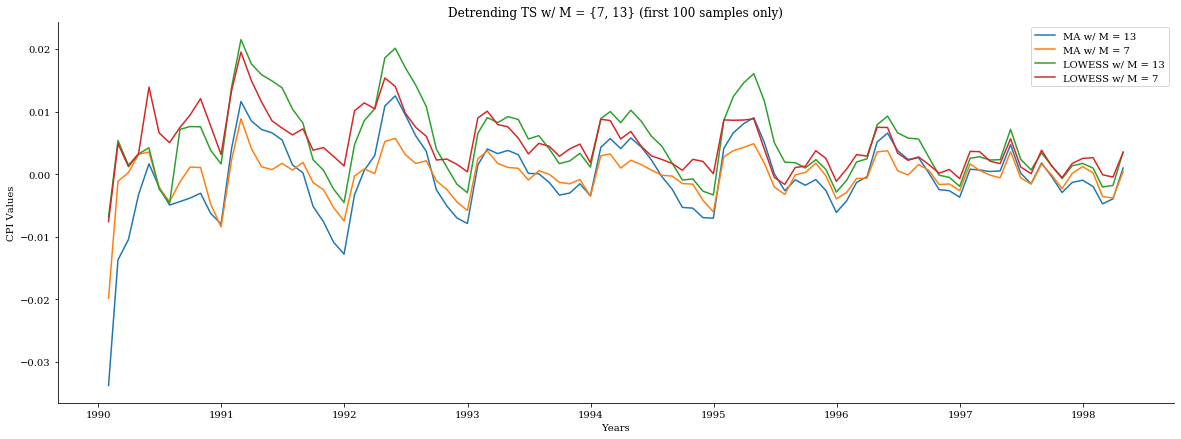

In [26]:
plt.rcParams['figure.figsize'] = (20, 7)

tsPlot(
	[
		maTsDetrended13[:100] - 1, 
		maTsDetrended7[:100] - 1, 
		lowessTsDetrended13[:100] - 1, 
		lowessTsDetrended7[:100] - 1
	],
	title='Detrending TS w/ M = {7, 13} (first 100 samples only)',
	xlabel='Years',
	ylabel='CPI Values',
	legend=[
		'MA w/ M = 13',
		'MA w/ M = 7',
		'LOWESS w/ M = 13',
		'LOWESS w/ M = 7',
	]
)

In [27]:
detrendedSeries: list = [
	linearTsDetrendedMult, 
	quadTsDetrendedMult, 
	maTsDetrended13,
	maTsDetrended7,
	lowessTsDetrended13,
	lowessTsDetrended7
]
mse: 'list[float]' = [ np.mean((dts - 1) ** 2)  for dts in detrendedSeries ]
mae: 'list[float]' = [ np.mean(np.abs(dts - 1)) for dts in detrendedSeries ]

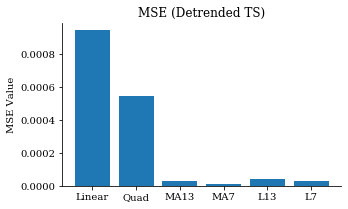

In [28]:
plt.rcParams['figure.figsize'] = (5, 3)

plt.bar(
	[
		'Linear', 'Quad', 
		'MA13', 
		'MA7', 
		'L13', 
		'L7',
	], mse
)
plt.ylabel('MSE Value')
plt.title('MSE (Detrended TS)')
plt.show()

#### 4.2 - Seasonality

##### I - DFT

In [29]:
def getFrequencies(ts, fs = 12):
	# Mean was subtracted because we want to
	# evaluate the importance of non-null frequency components
	dft = (np.abs(np.fft.rfft(ts - ts.mean())) ** 2 / ts.size)
	freq = np.fft.rfftfreq(ts.size, d=1/fs)
	return dft, freq

In [30]:
dftFreq: 'list[tuple]' = []
for dts in detrendedSeries[2:]:
	dft, freq = getFrequencies(dts)
	dftFreq += [(dft, freq)]

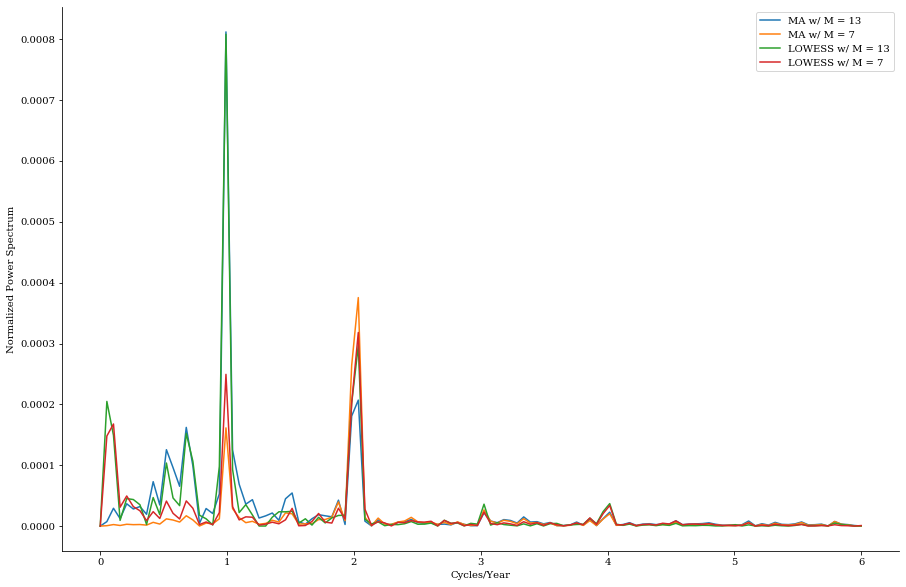

In [31]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.figure()
for pair in dftFreq:
	dft, freq = pair
	plt.plot(freq, dft)
	plt.xlabel('Cycles/Year')
	plt.ylabel('Normalized Power Spectrum')
plt.legend([
	'MA w/ M = 13', 
	'MA w/ M = 7', 
	'LOWESS w/ M = 13',
	'LOWESS w/ M = 7',
])
plt.show()

There appears to be a moderate amount of noise on frequencies below ~0.000175

In [32]:
def removeNoise(ft, threshold = 0.0002):
	return ft * (ft > threshold)

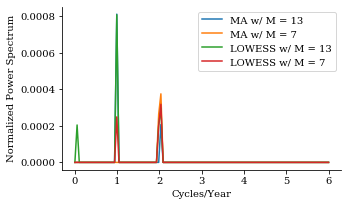

In [33]:
plt.rcParams['figure.figsize'] = (5, 3)
plt.figure()
for pair in dftFreq:
	dft, freq = pair
	plt.plot(freq, removeNoise(dft))
	plt.xlabel('Cycles/Year')
	plt.ylabel('Normalized Power Spectrum')
plt.legend([
	'MA w/ M = 13', 
	'MA w/ M = 7', 
	'LOWESS w/ M = 13',
	'LOWESS w/ M = 7',
])
plt.show()

After noise removal, we can see that both methods detect the expected patterns (annual and biannual), as well as an interesting ~0.1/0.2 Cycle/Year **[1]**. Logically, the M = 7 approaches assign more relevance to a biannual pattern.
Furthermore, we expected to obtain a 'clean' peak at the 1 cycle/year mark with all approaches, but instead got 2 peaks with MA (w/ M = 13). We hypothesise that this can be caused by recurring government subsidies, specific to the financial legislation of the country concerned, that cause an increase in consumer buying power, which in turn may alter the dynamic of the CPI for a short period of time.

**[1]** This can be explained by calculation errors in the LOWESS implementation. When the trend is not equal to 0 (i.e is not completely removed from the time series), the DFT analysis yields abnormal peaks near frequency 0.

##### II - Butterworth Filter

In [34]:
import scipy.signal as scs

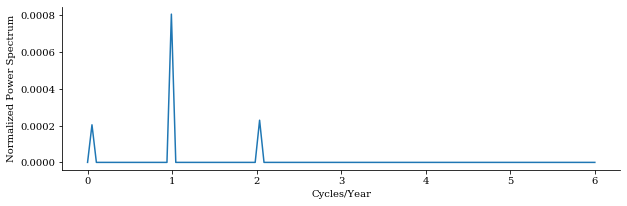

In [35]:
plt.rcParams['figure.figsize'] = (10, 3)

sos = scs.butter(
	N=5, fs=12,
	Wn=[2.4],
	output='sos'
)
seasonal_L13 = scs.sosfiltfilt(sos, lowessTsDetrended13)
dft, freq = getFrequencies(seasonal_L13)

plt.figure()
plt.plot(freq, removeNoise(dft))
plt.xlabel('Cycles/Year')
plt.ylabel('Normalized Power Spectrum')
plt.show()

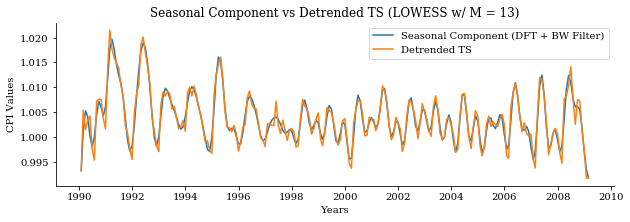

In [36]:
# Plot seasonal component
plt.figure()
tsSeasonal_L13 = pd.Series(
	data=seasonal_L13,
	index=lowessTsDetrended13.index,
)

seasonal_L7 = scs.sosfiltfilt(sos, lowessTsDetrended7)
tsSeasonal_L7 = pd.Series(
	data=seasonal_L7,
	index=lowessTsDetrended7.index,
)

seasonal_MA13 = scs.sosfiltfilt(sos, maTsDetrended13)
tsSeasonal_MA13 = pd.Series(
	data=seasonal_MA13,
	index=maTsDetrended13.index,
)

seasonal_MA7 = scs.sosfiltfilt(sos, maTsDetrended7)
tsSeasonal_MA7 = pd.Series(
	data=seasonal_MA7,
	index=maTsDetrended7.index,
)

tsPlot(
	[tsSeasonal_L13, lowessTsDetrended13],
	title='Seasonal Component vs Detrended TS (LOWESS w/ M = 13)',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['Seasonal Component (DFT + BW Filter)', 'Detrended TS']
)

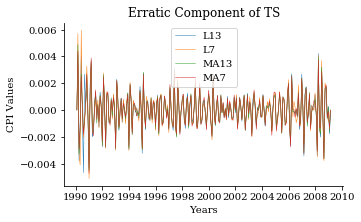

In [37]:
# Remove seasonal component, leaving the erratic component
plt.rcParams['figure.figsize'] = (5, 3)
plt.rcParams['lines.linewidth'] = 0.5

tsErratic_L13 = lowessTsDetrended13/tsSeasonal_L13
tsErratic_L7 = lowessTsDetrended7/tsSeasonal_L7
tsErratic_MA13 = maTsDetrended13/tsSeasonal_MA13
tsErratic_MA7 = maTsDetrended7/tsSeasonal_MA7

tsPlot(
	[tsErratic_L13 - 1, tsErratic_L7 - 1, tsErratic_MA13 - 1, tsErratic_MA7 - 1],
	title='Erratic Component of TS',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['L13', 'L7', 'MA13', 'MA7']
)

By removing the 3 most proeminent components of seasonality, we get a series that can be accepted as the erratic component of the TS.

##### III - Epoch Averaging

In [38]:
S = 12
N = lowessTsDetrended13[:-7].size
C = int(np.floor(N / S))

reshTs = lowessTsDetrended13[:-7].to_numpy().reshape((C, S))
ac = np.tile(np.mean(reshTs, axis=0), (C, ))
lowessTsDetrended13 = lowessTsDetrended13[:C*S]
seasonalEA = pd.Series(
	data=ac,
	index=lowessTsDetrended13.index,
)

tsPlot(
	[seasonalEA, lowessTsDetrended13],
	title='Seasonal Component vs Detrended TS (LOWESS w/ M = 13)',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['Seasonal Component (Epoch Averaging)', 'Detrended TS']
)

ValueError: cannot reshape array of size 223 into shape (18,12)

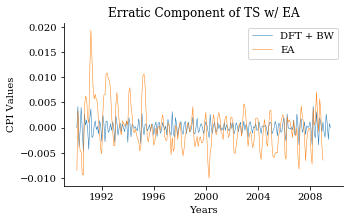

In [ ]:
# Remove seasonal component
tsErraticEA = lowessTsDetrended13/seasonalEA

tsPlot(
	[tsErratic_L13 - 1, tsErraticEA - 1],
	title='Erratic Component of TS w/ EA',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['DFT + BW', 'EA']
)

As we can observe on the plot above, the erratic component extracted using Epoch Averaging fails to remove seasonality at a 6-month level - we can still detect a repeating pattern along that frequency. Since we have already established that the shorter underlying patterns are still really relevant, we can discard Epoch Averaging as a valid approach for our use-case.

#### 4.3 - Differencing

##### I - 1st-Order Differencing

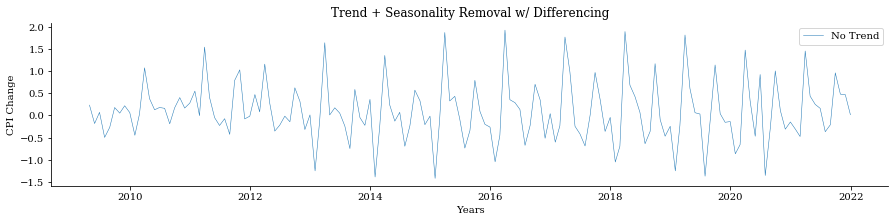

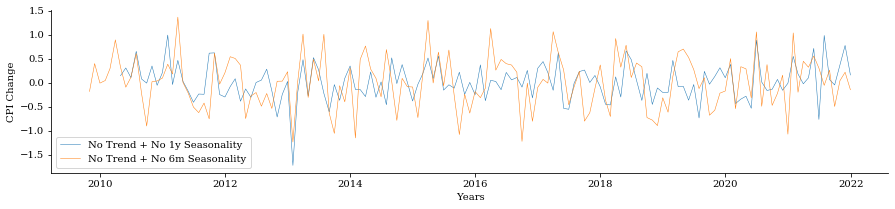

In [39]:
plt.rcParams['figure.figsize'] = (15, 3)
tsPlot(
	[tsTest.diff()],
	title='Trend + Seasonality Removal w/ Differencing',
	xlabel='Years',
	ylabel='CPI Change',
	legend=['No Trend']
)

tsPlot(
	[tsTest.diff().diff(12), tsTest.diff().diff(6)],
	title='',
	xlabel='Years',
	ylabel='CPI Change',
	legend=['No Trend + No 1y Seasonality', 'No Trend + No 6m Seasonality']
)

In [40]:
# Comparing erratic component extraction
# with diff(12m) vs with DFT + Butter vs EA
# -> Last 100 samples of training set only
tsPlot(
	[
		# tsTrain.diff().diff(12)[:100],
		tsErraticEA[:100] - 1,
		tsErratic_L13[:100] - 1,
	],
	title='Erratic Comp Extraction on Diff vs DFT + Butter vs EA',
	xlabel='Years',
	ylabel='CPI Values',
	legend=[
		# 'Differencing (12m)',
		'Epoch Averaging',
		'DFT + Butterworth'
	]
)

NameError: name 'tsErraticEA' is not defined

##### II - Autocorrelation & Correlogram

In [41]:
from scipy.stats import norm

def autocov(timeserie, T=0):
    N = timeserie.size
    mu = timeserie.mean()
    covCoef = 0
    for n in range(0, N - T - 1):
        covCoef=covCoef + (timeserie[n] - mu) * (timeserie[n+T] - mu)
    return covCoef / float(np.abs(N))
    
def autocoef(timeserie, T=0):
    return autocov(timeserie, T) / autocov(timeserie)

def correlogram(timeserie, maxT, twoside=False):
    N = timeserie.size
    if twoside:
        corrl = np.zeros(2 * maxT + 1)
        ix = np.array(range(maxT + 1))
        ix = np.concatenate((-np.flip(ix[1:]), ix), axis=0)
    else:
        corrl=np.zeros(maxT + 1)  
        ix=np.array(range(maxT + 1))
    
    for i in range(maxT + 1):
        if twoside:
            corrl[i + maxT]=autocoef(timeserie, i)
            if i > 0:
                corrl[maxT - i]=corrl[i + maxT]
        else:
            corrl[i] = autocoef(timeserie, i)
    d = {'ACS': corrl, 'upsig': np.ones(maxT+1)*(1.96 / np.sqrt(N)), 'dnsig': -np.ones(maxT + 1) * (1.96 / np.sqrt(N))}
    corrl = pd.DataFrame(data=d, index=ix)
    return corrl


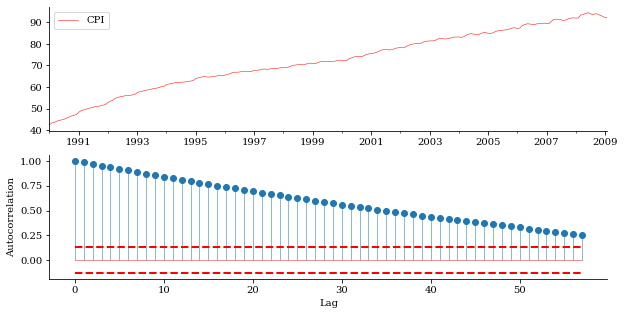

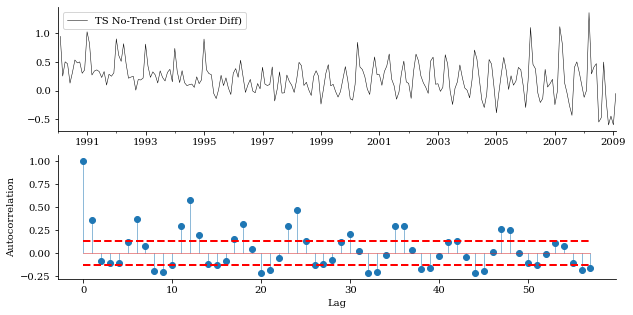

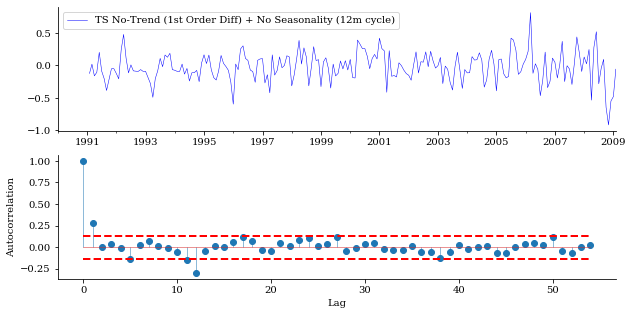

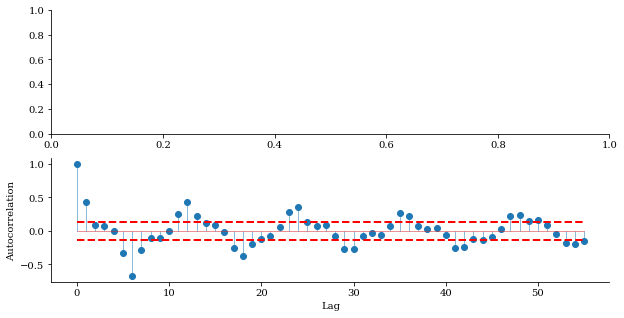

In [42]:
plt.rcParams['figure.figsize'] = (10, 5)

# Raw
fig, axs=plt.subplots(2)

tsTrain.plot(ax=axs[0],legend=True,color='r')
plt.ylabel('CPI Value')
plt.xlabel('Years')

N=tsTrain.size
corrl=correlogram(tsTrain, maxT=int(N/4))
corrl.name='Raw TS ACS'
axs[1].stem(corrl.index, corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# No trend-1st order diff
fig, axs=plt.subplots(2)

d1psTS = tsTrain.diff()
d1psTS.name='TS No-Trend (1st Order Diff)'
d1psTS.plot(ax=axs[0],legend=True,color='k')
plt.ylabel('CPI Value Change')
plt.xlabel('Years')

N=d1psTS.dropna().size

corrl = correlogram(d1psTS.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend)'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# No trend-1st order diff and no seasonality (seas. diff)
fig, axs=plt.subplots(2)

d1psTS = d1psTS.diff(12)
d1psTS.name = 'TS No-Trend (1st Order Diff) + No Seasonality (12m cycle)'
d1psTS.plot(ax=axs[0], legend=True, color='b')
plt.ylabel('CPI Value Change')
plt.xlabel('Years')

N=d1psTS.dropna().size

corrl = correlogram(d1psTS.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No Seasonality (12m cycle))'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# No trend-1st order diff and no seasonality (12m + 6m)
fig, axs=plt.subplots(2)

d1psTS = tsTrain.diff().diff(6)
d1psTS.name = 'No-trend + No 6-month cycle'
# d1psTS.plot(ax=axs[0], legend=True, color='b')
# plt.ylabel('CPI Value Change')
# plt.xlabel('Years')

N=d1psTS.dropna().size

corrl = correlogram(d1psTS.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No 6-month cycle)'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.show()

<ol>
	<li>
		As expected, the ACS plot for the raw TS demonstrates that there's a very visible long term trend (the ACS plot approximates 0 for large lags).
	</li>
	<li>
		In the 1st-order diff ACS, we can observe much more clearly the oscillations related to seasonality (around the 12-month and 6-month marks, as previously discussed). We can conclude that the ACS approach gives us a clearer insight on what seasonal patterns are present and further confirm our conclusions of multiple seasonal patterns.
		Furthermore, the plot shows us that there is a strong correlation around the 5 and 7-month marks. We can't really explain what socio-economic factors play into this phenomenon, but we hypothesize it might be related to the conclusions drawn from the DFT analysis using MA w/ W = 13, which shows a frequency peak at around the ~1.2 cycle/year mark.
	</li>
	<li>
		In the erratic component ACS extracted by removing the 12-month seasonal pattern, we can see that each sample <i>n</i> correlates negatively to the <i>n-12</i>th sample, and positively to the <i>n-1</i>th sample. In the fact, the absolute value of the <i>n-12</i>th sample's correlation outweighs the <i>n-1</i>th sample's one. This can be explained by the mere fact that there is in fact a 12-month seasonal pattern that is very much present. Furthermore, the ACS plot shows other correlations slightly above the confidence threshold (lag = {38, 50}). These are probably a result of computation errors due to small N.
		As such, we can conclude that the ACS plot indicates that this series is stationary (rapidly approximates ~0 for T>1)
	</li>
	<li>
		In the erratic component ACS extracted by removing the 6-month seasonal pattern, the negative correlation of the n-6th and n-12th samples is even more visible, which tells us that the approach used did not result in a stationary series. As such, we conclude that the erratic component extracted by removing the 12-month seasonal pattern is more representative.
	</li>
</ol>

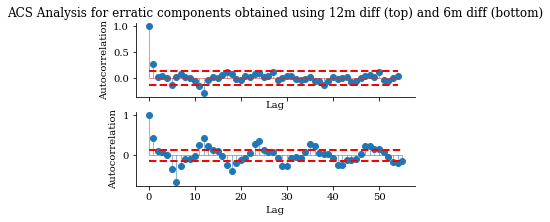

In [43]:
plt.rcParams['figure.figsize'] = (5, 3)

fig, axs=plt.subplots(2, 1, sharex=True)
# fig.title('ACS Analysis for erratic components obtained using 12m diff (top) and 6m diff (bottom)')

# No trend-1st order diff and no seasonality (seas. diff)
ts12 = tsTrain.diff().diff(12)
ts12.name = 'No trend + No Seasonality (12m cycle)'

N=ts12.dropna().size

corrl = correlogram(ts12.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No Seasonality (12m cycle))'
axs[0].stem(corrl.index, corrl['ACS'], use_line_collection=True)
axs[0].plot(corrl.index, corrl['upsig'], linestyle='--', color='r', linewidth=2)
axs[0].plot(corrl.index, corrl['dnsig'], linestyle='--', color='r', linewidth=2)
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('ACS Analysis for erratic components obtained using 12m diff (top) and 6m diff (bottom)')

# No trend-1st order diff and no seasonality (12m + 6m)
ts6 = tsTrain.diff().diff(6)
ts6.name = 'No trend + No Seasonality (6m cycle)'

N=ts6.dropna().size
corrl = correlogram(ts6.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No 6-month cycle)'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'], linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'], linestyle='--', color='r', linewidth=2)
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation')

# plt.legend(['No trend + No Seasonality (12m cycle)', 'No trend + No Seasonality (6m cycle)'])
plt.show()

#### 4.4 - Stationarity

A process is said to be WSS if the mean and autocorrelation/autocovariance functions are not dependent on the time that they are computed, i.e., if first and second-order statistical moments are constant along time. In common words, we say that a process is WSS if the mean and variance with (auto-covariance for $T=0$) are constant with time.

In [44]:
def meanvarWtime(timeseries, W = 2):
    Nwin = int(np.floor(timeseries.size / W))
    vals = timeseries.to_numpy()
    vals = vals[0: int(Nwin * W)]
    mvals = vals.reshape((Nwin, W))
    return {
	  'mu': np.mean(mvals, axis=1),
	  'var': np.var(mvals, axis=1)
	}

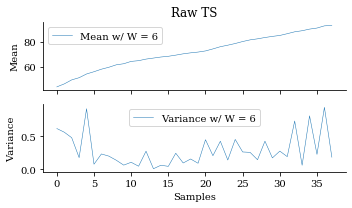

In [45]:
fig, axs=plt.subplots(
	2, tight_layout=True, sharex=True)

Win = 6
meanpsTSSeries = meanvarWtime(tsTrain, W=Win)['mu']
meanTS = pd.Series(
	data=meanpsTSSeries,
	index=np.array(range(meanpsTSSeries.size)),
	name=f'Mean w/ W = {Win}'
)
meanTS.plot(
	ax=axs[0], 
	title='Raw TS',
	xlabel='Samples', 
	ylabel='Mean', 
	legend=True
)

varpsTSSeries = meanvarWtime(tsTrain, W=Win)['var']
varTS = pd.Series(
	data=varpsTSSeries,
	index=np.array(range(varpsTSSeries.size)),
	name=f'Variance w/ W = {Win}'
)
varTS.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

plt.show()

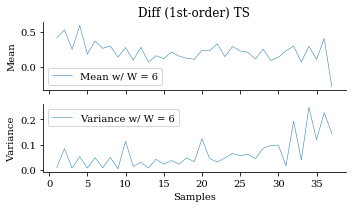

In [46]:
fig, axs=plt.subplots(
	2, tight_layout=True, sharex=True)

d1psTS=tsTrain.diff()

meanpsTSSeries = meanvarWtime(d1psTS, W=Win)['mu']
meanTS = pd.Series(
	data=meanpsTSSeries,
	index=np.array(range(meanpsTSSeries.size)),
	name=f'Mean w/ W = {Win}'
)
meanTS.plot(
	ax=axs[0], 
	title='Diff (1st-order) TS',
	xlabel='Samples', 
	ylabel='Mean', 
	legend=True
)

varpsTSSeries = meanvarWtime(d1psTS, W=Win)['var']
varTS = pd.Series(
	data=varpsTSSeries,
	index=np.array(range(varpsTSSeries.size)),
	name=f'Variance w/ W = {Win}'
)
varTS.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

plt.show()

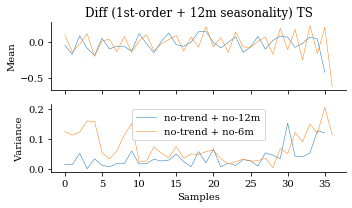

In [47]:
plt.rcParams['figure.figsize'] = (5, 3)


fig, axs=plt.subplots(
	2, tight_layout=True, sharex=True)

d1ps = tsTrain.diff()
d1psTS=tsTrain.diff().diff(12)
d1psTS_2=tsTrain.diff().diff(6)
d1psTS_3=tsTrain.diff().diff(6).diff(12)

d1ps = d1ps.dropna()
d1psTS = d1psTS.dropna()
d1psTS_2 = d1psTS_2.dropna()

meanpsTSSeries = meanvarWtime(d1psTS, W=Win)['mu']
meanTS = pd.Series(
	data=meanpsTSSeries,
	index=np.array(range(meanpsTSSeries.size)),
	name='no-trend + no-12m'
)
meanTS.plot(
	ax=axs[0], 
	title='Diff (1st-order + 12m seasonality) TS',
	xlabel='Samples', 
	ylabel='Mean', 
)

varpsTSSeries = meanvarWtime(d1psTS, W=Win)['var']
varTS = pd.Series(
	data=varpsTSSeries,
	index=np.array(range(varpsTSSeries.size)),
	name='no-trend + no-12m'
)
varTS.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

meanpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['mu']
meanTS_2 = pd.Series(
	data=meanpsTSSeries_2,
	index=np.array(range(meanpsTSSeries_2.size)),
	name='no-trend + no-6m'
)
meanTS_2.plot(
	ax=axs[0], 
	xlabel='Samples', 
	ylabel='Mean', 
)

varpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['var']
varTS_2 = pd.Series(
	data=varpsTSSeries_2,
	index=np.array(range(varpsTSSeries_2.size)),
	name='no-trend + no-6m'
)
varTS_2.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

# meanpsTSSeries_3 = meanvarWtime(d1psTS_3, W=Win)['mu']
# meanTS_3 = pd.Series(
# 	data=meanpsTSSeries_3,
# 	index=np.array(range(meanpsTSSeries_3.size)),
# 	name='no-trend + no-6m + no-12m'
# )
# meanTS_3.plot(
# 	ax=axs[0], 
# 	title=f'Diff no-trend no-12m vs no-trend no-6m vs no-trend no-6m no-12m TS (W={Win})',
# 	xlabel='Samples', 
# 	ylabel='Mean', 
# 	legend=True
# )

# varpsTSSeries_3 = meanvarWtime(d1psTS_3, W=Win)['var']
# varTS_3 = pd.Series(
# 	data=varpsTSSeries_3,
# 	index=np.array(range(varpsTSSeries_3.size)),
# 	name='no-trend + no-12m + no-6m'
# )
# varTS_3.plot(
# 	ax=axs[1],
# 	xlabel='Samples',
# 	ylabel='Variance',
# 	legend=True
# )

plt.show()

In [48]:
# fig, axs=plt.subplots(
# 	2, tight_layout=True, sharex=True)

# d1psTS_2=tsTrain.diff().diff(6).diff(12)

# meanpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['mu']
# meanTS_2 = pd.Series(
# 	data=meanpsTSSeries_2,
# 	index=np.array(range(meanpsTSSeries_2.size)),
# 	name=f'Mean w/ W = {Win}'
# )
# meanTS_2.plot(
# 	ax=axs[0], 
# 	title='Diff (1st-order + 12m seasonality + 6m seasonality) TS',
# 	xlabel='Samples', 
# 	ylabel='Mean', 
# 	legend=True
# )

# varpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['var']
# varTS_2 = pd.Series(
# 	data=varpsTSSeries_2,
# 	index=np.array(range(varpsTSSeries_2.size)),
# 	name=f'Variance w/ W = {Win}'
# )
# varTS_2.plot(
# 	ax=axs[1],
# 	xlabel='Samples',
# 	ylabel='Variance',
# 	legend=True
# )

# plt.show()

For a window of 6 and given the plots for both 12m and 6m seasonalities, we can infer that the erratic component produced by the removal of the 6m (2 cycle/year) pattern seems **less** stationary than the 12m-only one. The mean+variance on the 12m+6m have more oscillation over time, and the 6m has higher overall variance values. It's important to note that increases in the window value (12, 18 and 24) corroborate these results.

We can also use a statistical test - Augmented Dickey-Fuller Test, or ADF for short - to further test the stationarity of the resulting erratic component.

In [49]:
import statsmodels.tsa.stattools as st

def adf(seriesName, ts) -> None:
    adfStatistic,  \
    pValue, \
    _, _, \
    criticalValues, _ = st.adfuller(ts)
    print(
        f'''
        Series Name: {seriesName}
        ADF Statistic: {adfStatistic},
        p-value: {pValue} -> TS is {'' if pValue < 0.05 else 'non-'}stationary,
        Critical Values: {criticalValues}
        '''
    )

adf('Raw TS', tsTrain)
adf("No-trend TS (1st-order)", tsTrain.diff().dropna())
adf("No-trend and no-12m seasonal pattern TS", tsTrain.diff().diff(12).dropna())
adf("No-trend and no-6m seasonal pattern TS" , tsTrain.diff().diff(6).dropna())



        Series Name: Raw TS
        ADF Statistic: -1.621188964293287,
        p-value: 0.4721060243937479 -> TS is non-stationary,
        Critical Values: {'1%': -3.4609922013325267, '5%': -2.875015740963014, '10%': -2.5739524288408777}
        

        Series Name: No-trend TS (1st-order)
        ADF Statistic: -2.4659917532176037,
        p-value: 0.1239696525039049 -> TS is non-stationary,
        Critical Values: {'1%': -3.4609922013325267, '5%': -2.875015740963014, '10%': -2.5739524288408777}
        

        Series Name: No-trend and no-12m seasonal pattern TS
        ADF Statistic: -5.011724458342565,
        p-value: 2.1037449758556263e-05 -> TS is stationary,
        Critical Values: {'1%': -3.462818103072159, '5%': -2.8758145932936805, '10%': -2.574378674548251}
        

        Series Name: No-trend and no-6m seasonal pattern TS
        ADF Statistic: -9.045084548111562,
        p-value: 5.011943844802857e-15 -> TS is stationary,
        Critical Values: {'1%': -3.4609

### 5 - Model Fitting

Given the fact our data is seasonal and non-stationary (as demonstrated above), the only algorithm with the ability to accurately model and predict our TS is *Seasonal Autoregressive Integrated Moving Average* or **SARIMA**.
We showed in the chapter Basic Description Techniques that a TS can become stationary by simple differencing and by seasonal differencing. Usually, no more than $d=1$ and $D=1$ is necessary, but it is possible to apply higher differencing orders. The selection of $d$ and $D$ should follow the following steps:
<ol>
  <li>
    Verify if the original TS is stationary. If so, we are done with $d=0$ and $D=0$;
  </li>
  <li>
    If the series is not stationary and has a trend apply a simple differencing operation to remove the trend. If trend is removed then $d=1$, if not apply $d=2$ (Should be enough!!).
  </li>
  <li>
    With trend removed, and if seasonality is present, the ACS should present periodic peaks at each $S$ lags. If no peaks appear then no seasonal pattern exists and D=0. Otherwise, apply a first-order seasonal differencing. If ACS peaks disappear, then $D=1$. This step can be repeated. In the end, we have $D$ and $S$ identified.
  </li>
  <li>
    We have now to define $p$, $q$, $P$ and $Q$. We can look at the ACS and PACS to find out what should be the appropriate orders. For $p$ and $q$, we should only observe the ACS and PACS between $T=1$ and $T<S$ and proceed as for ARMA. To inspect $P$ and $Q$ we can resample the ACS and PACF at each $S$ lag and look when the re-sampled functions fall out. However, inspecting orders based on ACS and PACF may be difficult, and usually, a grid-search is implemented.
  </li>
</ol>

As was previously studied, our raw data presents a trend that is removable by differencing with $d=1$. Furthermore, we have also concluded that the removal of the 12m seasonality pattern yields a more stationary erratic component. <p>
As such, we can define $d=1$, $D=1$ and $S=12$.

In [50]:
def SARIMA(acoefs, d, mcoefs, Acoefs, D, Mcoefs, s, N, noise=1):
    if d>0:
        d1=np.array([1,-1])
        dpoly=d1
        if d>1:
            for i in range(d-1):
                dpoly=np.convolve(dpoly,d1)
        dpoly=dpoly
    else:
        dpoly=np.array([1])
    
    if D>0:
        D1=np.concatenate((np.array([1]),np.zeros(s-1),np.array([-1])),axis=0)
        Dpoly=D1
        if D>1:
            for i in range(D-1):
                Dpoly=np.convolve(Dpoly,D1)
        Dpoly=Dpoly
    else:
        Dpoly=np.array([1])
    
    Ac=np.zeros(Acoefs.size*s+1)
    k=0
    for i in range(s,Acoefs.size*s+1,s):
        Ac[i]=-Acoefs[k]
        k=k+1
    Ac[0]=1
    
    ac=np.zeros(acoefs.size+1)
    k=0
    for i in range(1,acoefs.size+1):
        ac[i]=-acoefs[k]
        k=k+1
    ac[0]=1
    
    Mc=np.zeros(Mcoefs.size*s+1)
    k=0
    for i in range(s,Mcoefs.size*s+1,s):
        Mc[i]=Mcoefs[k]
        k=k+1
    Mc[0]=1
    
    mc=np.zeros(mcoefs.size+1)
    k=0
    for i in range(1,mcoefs.size+1):
        mc[i]=mcoefs[k]
        k=k+1
    mc[0]=1
    
    Xcoef=np.convolve(np.convolve(np.convolve(ac,Ac),dpoly),Dpoly)[1:]
    Zcoef=np.convolve(mc,Mc)
    
    mx_coefs=max(Xcoef.size,Zcoef.size)
    Z=np.random.randn(N)*np.sqrt(noise)
    SARIMA=np.zeros(N)
    k=0
    for i in range(mx_coefs-1,N):
        for j in range(Xcoef.size):
            SARIMA[i]=SARIMA[i]-SARIMA[i-j-1]*Xcoef[j]
        SARIMA[i]=SARIMA[i]+Z[i]
        for j in range(Zcoef.size-1):
            SARIMA[i]=SARIMA[i]+Z[i-j-1]*Zcoef[j+1]
    strname="SARIMA("+str(acoefs.size)+","+str(d)+","+str(mcoefs.size)+")X("+str(Acoefs.size)+","+str(D)+","+str(Mcoefs.size)+")"+str(s)
    return pd.Series(data=SARIMA[mx_coefs-1:],index=np.array(range(mx_coefs-1,N,1)),name=strname) 

In [51]:
from statsmodels.tsa.arima.model import ARIMA

def gridSearch(ts, d, D, rp, rq, rP, rQ):
    aicV=np.zeros((len(rp), len(rq), len(rP), len(rQ)))
    i=0
    for p in rp:
        j=0
        for q in rq:
            k=0
            for P in rP:
                l=0
                for Q in rQ:
                    model = ARIMA(
                        ts, 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, 12)
                    )
                    fit = model.fit()
                    aicV[i][j][k][l]=fit.aicc
                    l=l+1
                k=k+1
            j=j+1
        i=i+1   
    ixs=np.where(aicV==np.min(aicV))
    # best params: p, q, P, Q, AIC (str)
    return rp[ixs[0][0]], rp[ixs[1][0]], rP[ixs[2][0]], rQ[ixs[3][0]], str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]])

Text(0, 0.5, 'Partial AutoCorr')

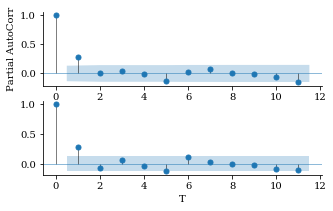

In [52]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, axs = plt.subplots(2)
plot_acf(tsTrain.diff().diff(12).dropna(), lags=11, ax=axs[0], title='')
plot_pacf(tsTrain.diff().diff(12).dropna(), lags=11, ax=axs[1], title='')
axs[0].set_xlabel('T')
axs[0].set_ylabel('AutoCorr')
axs[1].set_xlabel('T')
axs[0].set_ylabel('Partial AutoCorr')

Observing the ACS and PACS, we can observe that both converge to 0 for $T > 1$. This confirms the stationarity observed in the characterization stage. With this information, we can estimate $p = 1$ and $q = 1$, and as such, only $P$ and $Q$ are left for estimation.
We will observe the ACS and PACS plots for lags that are multiples of our seasonal period, i.e. [0, 12, 24, 36].

Text(18.125, 0.5, 'Partial AutoCorr')

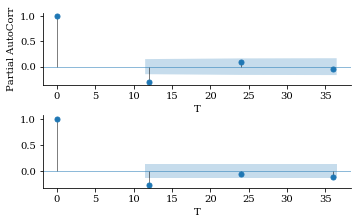

In [53]:
fig, axs = plt.subplots(2)
fig.tight_layout()
plot_acf(
	tsTrain.diff().diff(12).dropna(), 
	lags=range(0, 40, 12),
	ax=axs[0], 
	title=''
)
plot_pacf(
	tsTrain.diff().diff(12).dropna(),
 	lags=range(0, 40, 12), 
	ax=axs[1], 
	title=''
)
axs[0].set_xlabel('T')
axs[0].set_ylabel('AutoCorr')
axs[1].set_xlabel('T')
axs[0].set_ylabel('Partial AutoCorr')

Analyzing only the ACS and PACS can be misleading. As such, we compute the optimal parameters (i.e minimal AICC) using grid search.

In [54]:
rp = range(0,3)
rq = range(0,3)
rP = range(0,2)
rQ = range(0,2)
d = 1
D = 1
gridSearch(tsTrain, d, D, rp, rq, rP, rQ)

(0, 1, 1, 0, '-71.7871349315638')

By computing the residuals, we can assess the model's fit to our training data. Good fittings should result in a residual signal with zero mean and ACS plot with a single value significantly different from zero (at lag 0). In other words, the residuals should not contain any structure, which corresponds to a better overall fit. So, a good assessment strategy is to compute the residuals mean and its ACS. Consider the code below that simulate an AR(2) process, estimate its parameters and evaluate the behavior of the residuals.

In [55]:
# get fitted data w/ the best params obtained w/ grid search
# (0, 1, 1, 0, '-65.82697210358465')
d, D = 1, 1
p, q, P, Q = 0, 1, 1, 0
model = ARIMA(tsTrain, order=(p, d, q), seasonal_order=(P, D, Q, 12))
tsFit = model.fit().predict()

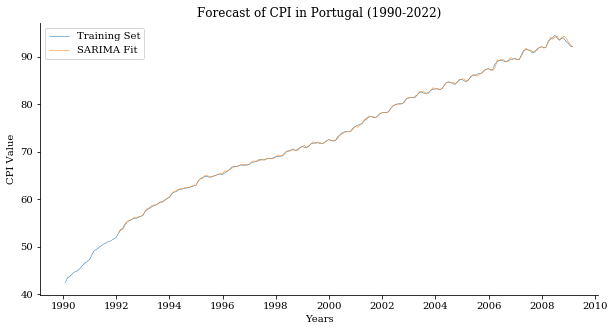

In [56]:
plt.rcParams['figure.figsize'] = (10, 5)

tsPlot(
	[tsTrain, tsFit[2*12:]], 
	title='Forecast of CPI in Portugal (1990-2022)', 
	xlabel='Years', 
	ylabel='CPI Value',
	legend=['Training Set', 'SARIMA Fit']
)

Residuals Mean: 0.021066415745782052


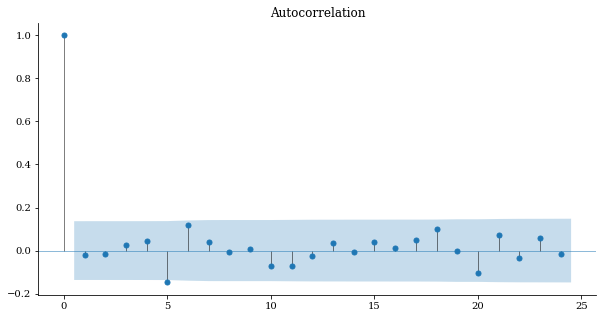

In [57]:
# Compute residuals
tsResiduals = (tsFit[2*12:] - tsTrain).dropna()
print(f'Residuals Mean: {tsResiduals.mean()}')

# plot residual ACS
fig = plot_acf(tsResiduals)

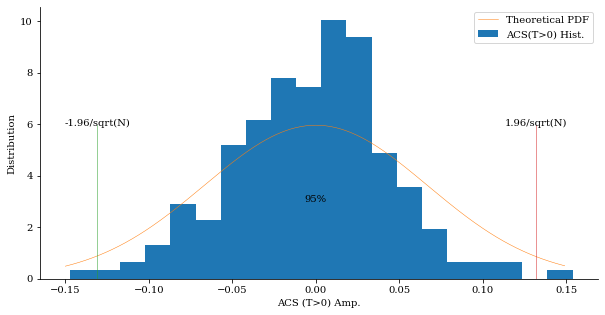

In [58]:
from statsmodels.tsa.stattools import acf
import scipy.stats as spyst

ac=acf(tsResiduals, nlags=2000, fft=False)
plt.figure()
plt.hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

rg=np.arange(-0.15, 0.15, 0.001)
pdf = spyst.norm.pdf(rg, 0, 1/np.sqrt(N))
cdf = spyst.norm.cdf(rg, 0, 1/np.sqrt(N))

aix005=np.where(cdf>=0.025)
ix005=aix005[0][0]
aix095=np.where(cdf>=0.975)
ix095=aix095[0][0]

plt.plot(rg,pdf,label='Theoretical PDF')
plt.plot([rg[ix005],rg[ix005]],[0,np.max(pdf)])
plt.plot([rg[ix095],rg[ix095]],[0,np.max(pdf)])
plt.text(rg[ix005],np.max(pdf),"-1.96/sqrt(N)",horizontalalignment="center")
plt.text(rg[ix095],np.max(pdf),"1.96/sqrt(N)",horizontalalignment="center")
plt.text(0,np.max(pdf)/2,"95%",horizontalalignment="center")
#axs[1].legend('White noise ACS')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()

### 6 - TS Forecasting

In [59]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt

In [60]:
stepsAhead = 12

#### 6.1 - SES

In [61]:
smoothingLevels = [0.2, 0.6, 0.8, 'auto']
fits = []
for sl in smoothingLevels:
	if sl == 'auto':
		fit = SimpleExpSmoothing(
			tsTrain, 
			initialization_method="estimated"
		).fit()
	else: 
		fit = SimpleExpSmoothing(
			tsTrain, 
			initialization_method="heuristic"
		).fit(smoothing_level=sl, optimized=False)

	name = f'{fit.model.params["smoothing_level"]} (estimated)' if sl == 'auto' else sl
	forecast = fit \
		.forecast(stepsAhead) \
		.rename(r"$\alpha=%s$" % name)
	fits += [[ fit, forecast ]]

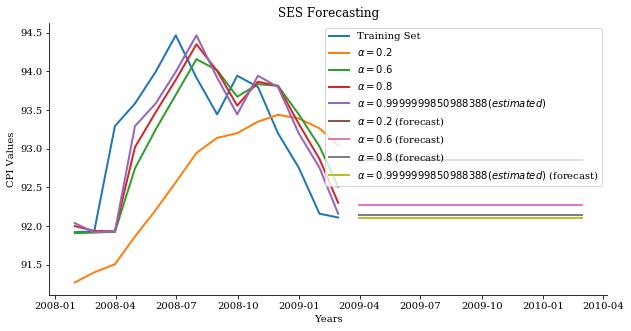

In [62]:
plt.rcParams['lines.linewidth'] = 2


cutoffYear = '2008'
tsPlot(
	[ 
		tsTrain[cutoffYear:], 
		# fits
		fits[0][0].fittedvalues[cutoffYear:],
		fits[1][0].fittedvalues[cutoffYear:],
		fits[2][0].fittedvalues[cutoffYear:],
		fits[3][0].fittedvalues[cutoffYear:],
		# forecasts
		fits[0][1],
		fits[1][1],
		fits[2][1],
		fits[3][1],
	],
	f'SES Forecasting',
	'Years', 'CPI Values',
	[ 
		'Training Set', 
		fits[0][1].name,
		fits[1][1].name,
		fits[2][1].name,
		fits[3][1].name,
		f'{fits[0][1].name} (forecast)',
		f'{fits[1][1].name} (forecast)',
		f'{fits[2][1].name} (forecast)',
		f'{fits[3][1].name} (forecast)',
	]
)

#### 6.2 - DES

In [63]:
smoothing = [(0.8, 0.2), (0.4, 0.5), (0.2, 0.6)]
fits = []
for smoothingLevel, smoothingTrend in smoothing:
	if sl == 'auto':
		fit = Holt(
			tsTrain, 
			initialization_method="estimated"
		).fit(
			smoothing_level=smoothingLevel,
			smoothing_trend=smoothingTrend,
			optimized=True
		)
	forecast = fit \
		.forecast(stepsAhead) \
		.rename(r"$\alpha=%s$, $\gamma=%s$" % (smoothingLevel, smoothingTrend))
	fits += [[ fit, forecast ]]

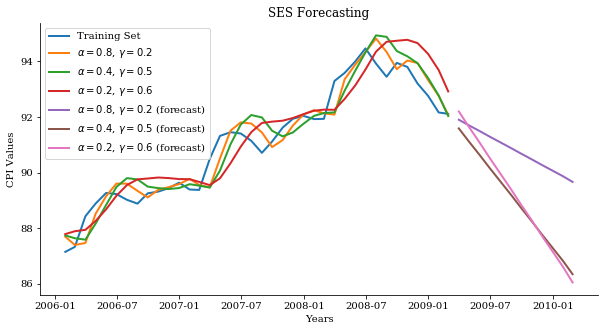

In [64]:
plt.rcParams['lines.linewidth'] = 2

cutoffYear = '2006'
tsPlot(
	[ 
		tsTrain[cutoffYear:], 
		# fits
		fits[0][0].fittedvalues[cutoffYear:],
		fits[1][0].fittedvalues[cutoffYear:],
		fits[2][0].fittedvalues[cutoffYear:],
		# forecasts
		fits[0][1],
		fits[1][1],
		fits[2][1],
	],
	f'SES Forecasting',
	'Years', 'CPI Values',
	[ 
		'Training Set', 
		fits[0][1].name,
		fits[1][1].name,
		fits[2][1].name,
		f'{fits[0][1].name} (forecast)',
		f'{fits[1][1].name} (forecast)',
		f'{fits[2][1].name} (forecast)',
	]
)

#### 6.3 - TES

In [65]:
def TES(serie, alpha, gamma, delta, S, NstepAh, mtype='m'):
    N=serie.size
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    I=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)
    L[S-1]=np.mean(serie[0:S])
    s[S-1]=L[S-1]
    tsum=0

    for i in range(S):
        tsum=tsum+(serie[i+1]-serie[i])
        if mtype=='m':#If multiplicative
            I[i]=serie[i]/L[S-1]
        else:
            I[i]=serie[i]-L[S-1]
            
    T[S-1]=(1/(S-1))*tsum
    for n in range(S,N):
        if mtype=='m':
            L[n]=alpha*(serie[n]/I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        else:
            L[n]=alpha*(serie[n]-I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        if mtype=='m':
            I[n]=delta*(serie[n]/L[n])+(1-delta)*I[n-S]
            s[n]=(L[n]+T[n])*I[n]
        else:
            I[n]=delta*(serie[n]-L[n])+(1-delta)*I[n-S]
            s[n]=L[n]+T[n]+I[n]
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
            if mtype=='m':
                s[n]=(L[N-1]+h*T[N-1])*I[N-S+np.mod(h-1,S)]
            else:
                s[n]=L[N-1]+h*T[N-1]+I[N-S+np.mod(h-1,S)]
            h=h+1
    oindex=serie.index
    index=oindex.union(pd.date_range(oindex[-1] + oindex.freq, periods=NstepAh, freq=oindex.freq))
    return pd.Series(s, index)
    

In [66]:
def TESGridSearch(tsTrain, tsVal, alphas, gammas, deltas):
	for_perf=np.zeros((alphas.size,gammas.size,deltas.size))
	i=0
	for alpha in alphas:
			j=0
			for gamma in gammas:
					k=0
					for delta in deltas:
							tes=TES(tsTrain, alpha, gamma, delta, 12, stepsAhead, mtype='m')
							outsamp=tes[-stepsAhead:]
							
							# RMSE as optimization metric
							for_perf[i][j][k]=np.sqrt(np.sum((tsVal - outsamp)**2)/outsamp.size)
							k=k+1
					j=j+1
			i=i+1

	# best params: alpha, gamma, delta
	ix = np.where(for_perf == np.min(for_perf))
	return alphas[ix[0]], gammas[ix[1]], alphas[ix[2]], np.min(for_perf)


In [67]:
step = 0.1
alphas = np.arange(step, 1-step, step)
gammas = np.arange(step, 1-step, step)
deltas = np.arange(step, 1-step, step)

# split test set in half - validation + testing
tsVal, tsTest = splitDataset(tsTest, 0.5)

print('Searching for optimal params...')
bestParams = TESGridSearch(tsTrain, tsVal, alphas, gammas, deltas)
print(f'''
Best Params:
-> Alpha: {bestParams[0]}
-> Gamma: {bestParams[1]}
-> Delta: {bestParams[2]}
---------
RMSE: {bestParams[3]}
'''
)

Searching for optimal params...

Best Params:
-> Alpha: [0.5]
-> Gamma: [0.1]
-> Delta: [0.8]
---------
RMSE: 0.2472144798773068



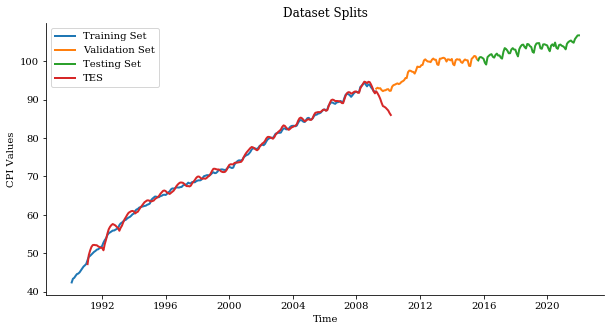

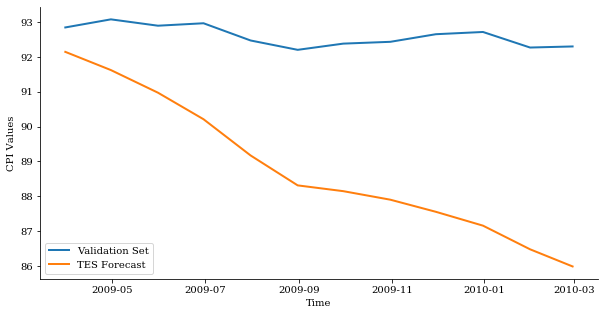

RMSE (Forecast) = 0.9277988071897417


In [68]:
# apply best params found by grid search
# assuming multiplicative decomp model
tsTES = TES(tsTrain, 0.3, 0.4, 0.4, 12, stepsAhead, mtype='m')
tsPlot(
	[tsTrain, tsVal, tsTest, tsTES[stepsAhead:]],
	'Dataset Splits',
	'Time', 'CPI Values',
	[ 'Training Set', 'Validation Set', 'Testing Set', 'TES']
)
tsPlot(
	[ tsVal[:stepsAhead], tsTES[-stepsAhead:] ],
	'',
	'Time',
	'CPI Values',
	['Validation Set', 'TES Forecast']
)
print("RMSE (Forecast) = " + str(np.sqrt(np.sum((tsVal - tsTES)**2) / tsTES.size)))

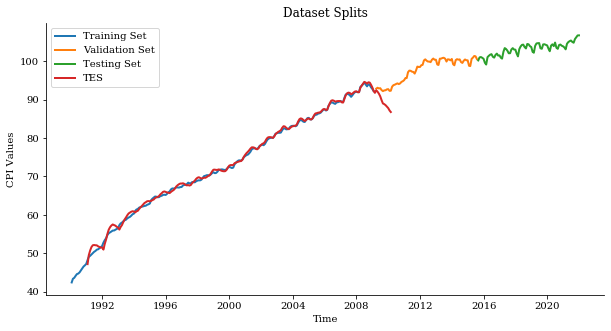

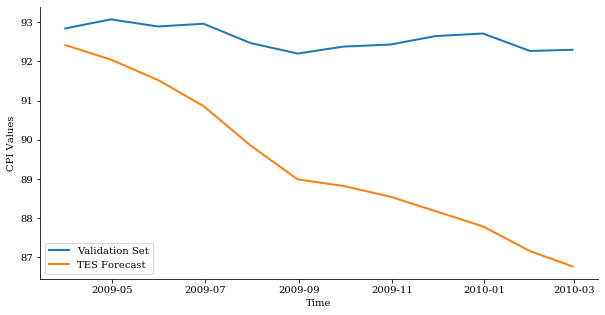

RMSE (Forecast) = 0.797064362583239


In [69]:
# apply best params found by grid search
# assuming multiplicative decomp model
tsTES = TES(tsTrain, 0.3, 0.4, 0.4, 12, mtype='a', NstepAh=stepsAhead)
tsPlot(
	[tsTrain, tsVal, tsTest, tsTES[stepsAhead:]],
	'Dataset Splits',
	'Time', 'CPI Values',
	[ 'Training Set', 'Validation Set', 'Testing Set', 'TES']
)
tsPlot(
	[ tsVal[:stepsAhead], tsTES[-stepsAhead:] ],
	'',
	'Time',
	'CPI Values',
	['Validation Set', 'TES Forecast']
)
print("RMSE (Forecast) = " + str(np.sqrt(np.sum((tsVal - tsTES)**2) / tsTES.size)))

These results further confirm that assuming a multiplicative model is the way to go.

#### 6.4 - SARIMA

Since the ACS & PACS plots are useful for getting a sense of what the upper bound for what values p, q, P, Q should take, using the values obtained by the grid search seems like the most sensible approach. Furthermore, we had already established that those same values yielded a proper fit to our data.

In [70]:
rp = range(0,3)
rq = range(0,3)
rP = range(0,2)
rQ = range(0,2)

# Returns p, q, P, Q, AICC Score
gridSearch(tsTrain, 1, 1, rp, rq, rP, rQ)

(0, 1, 1, 0, '-71.7871349315638')

In [71]:
d, D = 1, 1
p, q, P, Q = 0, 1, 1, 0
model = ARIMA(tsTrain, order=(p, d, q), seasonal_order=(P, D, Q, 12))
fit = model.fit()
forecast = fit.forecast(tsVal.size + tsTest.size)

In [72]:
print('AICC Score: ', fit.aicc)
print('Forecast RMSE: ', np.sqrt(np.sum((tsVal - forecast)**2) / forecast.size))

AICC Score:  -71.7871349315638
Forecast RMSE:  1.7236069760795942


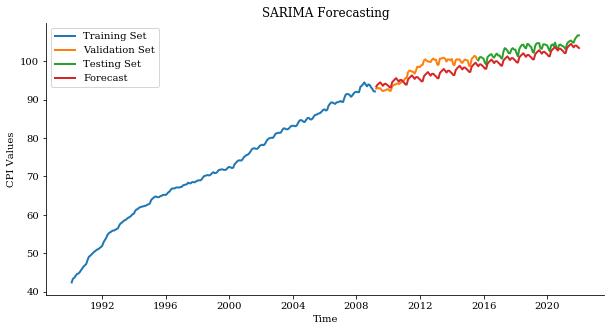

In [73]:
tsPlot(
	[ tsTrain, tsVal, tsTest, forecast ],
	'SARIMA Forecasting',
	'Time', 'CPI Values',
	[ 'Training Set', 'Validation Set', 'Testing Set', 'Forecast' ]
)

Thoughts:
- (outlier) Eliminar os dados do market crash faz com que a forecast melhore (obviamente, menos bias de acontecimentos esporádicos, torna-se + generalizável), portanto, acho que faz sentido treinar o SARIMA com dados ATÉ à data dessa ocorrência.
- (outlier) Remover fim da TS é indicado? É um outlier, e influencia demasiado o forecast
- O SARIMA está a assumir uma trend completamente linear. Tendo em conta que ela se achata mais perto de 2022, como é que eu forço um dampening da trend - à moda do TES? 
- O SARIMA adapta-se imenso ao fim dos dados

Posso aumentar o tamanho da training data, para tentar que o efeito do market crash se dilua + dá oportunidade ao SARIMA para se ajustar a uma trend (aparentemente) mais logarítmica (ela meio que achata). <p>
experimentar:
- remover ultimo ano da ts
- usar o agora ultimo ano da ts para testar
- usar o resto para treinar

In [74]:
# Remove last year of cpi samples, as it is clearly an outlier 
# and hurts our chances of obtaining a good prediction
ts = ts[:'2021']

In [75]:
tsTrain, tsTest = splitDataset(ts, 1 - (12 / ts.size))

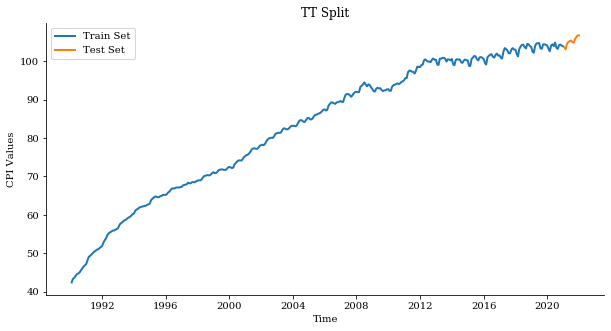

In [76]:
tsPlot(
	[ tsTrain, tsTest ],
	'TT Split',
	'Time', 'CPI Values',
	[ 'Train Set', 'Test Set' ]
)

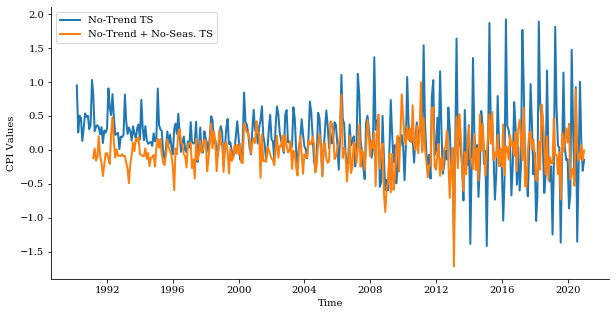

In [77]:
tsPlot(
	[ tsTrain.diff(), tsTrain.diff().diff(12) ],
	'', 'Time', 'CPI Values',
	[ 'No-Trend TS', 'No-Trend + No-Seas. TS' ]
)

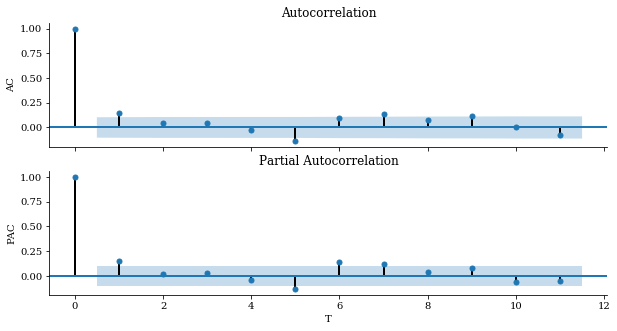

In [78]:
# Check if the resulting TS is stationary
# and infer p and q based on ACS+PACS observation
_, axs = plt.subplots(2, sharex=True)
plot_acf(tsTrain.diff().diff(12).dropna(), ax=axs[0], lags=11)
plot_pacf(tsTrain.diff().diff(12).dropna(), ax=axs[1], lags=11)
axs[1].set_xlabel('T')
axs[0].set_ylabel('AC')
axs[1].set_ylabel('PAC')
plt.show()

Since the time series is stationary, we can conclude that $d = 1$ and $D = 1$. Furthermore, both the ACS and PACS enter the confidence bounds after T > 1, so we can estimate that $q = 1$ and $p = 1$

In [79]:
# TS is stationary
adf(seriesName='', ts=tsTrain.diff().diff(12).dropna())


        Series Name: 
        ADF Statistic: -6.6533882211177495,
        p-value: 5.054576752003728e-09 -> TS is stationary,
        Critical Values: {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}
        


In [80]:
# Use Grid Search to get the real 'best' SARIMA params
rp = range(0,3)
rq = range(0,3)
rP = range(0,3)
rQ = range(0,3)

# Returns p, q, P, Q, AICC Score
gridSearch(tsTrain, 1, 1, rp, rq, rP, rQ)

(0, 1, 2, 2, '68.19607134890866')

In [81]:
# Feed gs params into SARIMA
d, D = 1, 1
p, q, P, Q = 0, 1, 2, 2
model = ARIMA(tsTrain, order=(p, d, q), seasonal_order=(P, D, Q, 12))
fit = model.fit()
sarimaForecast = fit.forecast(tsTest.size)
residuals = fit.resid[1:]

In [82]:
sarimaRMSE = np.sqrt(np.sum((tsTest - sarimaForecast)**2) / sarimaForecast.size)
print('Forecast RMSE: ', sarimaRMSE)

Forecast RMSE:  1.5249322084167276


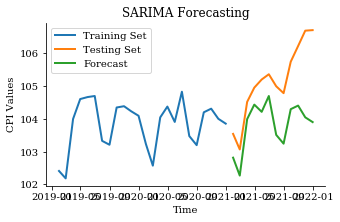

In [137]:
plt.rcParams['figure.figsize'] = (5, 3)
tsPlot(
	[ tsTrain[-12 * 2:], tsTest, sarimaForecast ],
	'SARIMA Forecasting',
	'Time', 'CPI Values',
	[ 'Training Set', 'Testing Set', 'Forecast' ]
)

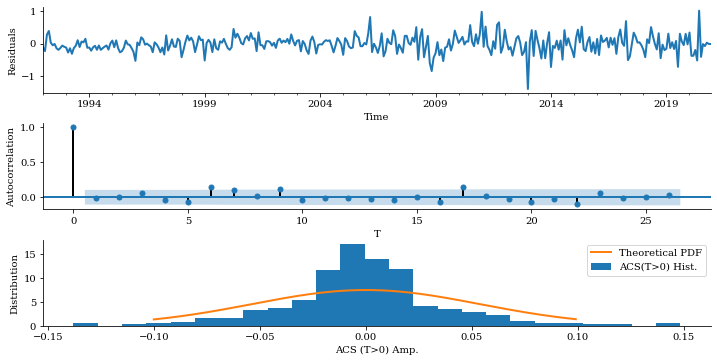

In [84]:
# Remove outlier
residuals = residuals['1992':]

#Evaluate fitting quality by inspecting residuals at three levels: 
# Time plot, ACS and ACS distribution
fig, axs=plt.subplots(3)
fig.tight_layout()
residuals.plot(ax=axs[0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
plot_acf(residuals,ax=axs[1],title="")
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

ac=acf(residuals,nlags=500,fft=False)

axs[2].hist(ac[1:], bins=25, density=True, label='ACS(T>0) Hist.')

N = residuals.size
rg = np.arange(-0.1, 0.1, 0.001)
pdf = spyst.norm.pdf(rg, 0, 1/np.sqrt(N))
plt.plot(rg, pdf, label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()
plt.show()

In [85]:
# Apply TES to new datasets
step = 0.1
alphas = np.arange(step, 1-step, step)
gammas = np.arange(step, 1-step, step)
deltas = np.arange(step, 1-step, step)

print('Searching for optimal params...')
bestParams = TESGridSearch(tsTrain, tsTest, alphas, gammas, deltas)
print(f'''
Best Params:
-> Alpha: {bestParams[0]}
-> Gamma: {bestParams[1]}
-> Delta: {bestParams[2]}
---------
RMSE: {bestParams[3]}
'''
)

Searching for optimal params...

Best Params:
-> Alpha: [0.2]
-> Gamma: [0.7]
-> Delta: [0.2]
---------
RMSE: 0.5989817114068335



In [86]:
tesForecast = TES(tsTrain, 0.2, 0.7, 0.2, 12, 12, mtype='m')

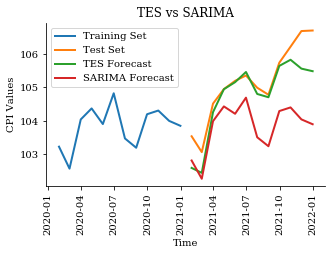

In [142]:
plt.rcParams['figure.figsize'] = (5, 3)

tsPlot(
	[tsTrain[-12:], tsTest, tesForecast[-12:], sarimaForecast],
	'TES vs SARIMA',
	'Time', 'CPI Values',
	[ 'Training Set', 'Test Set', 'TES Forecast', 'SARIMA Forecast'],
	rotateLabels=True
)

In [118]:
tesRMSE = str(np.sqrt(np.sum((tsTest - tesForecast)**2) / tesForecast.size))
print("TES RMSE (Forecast) = " + tesRMSE)
print("SARIMA RMSE (Forecast) = " + str(np.sqrt(np.sum((tsTest - sarimaForecast)**2) / sarimaForecast.size)))


TES RMSE (Forecast) = 0.10588600748562389
SARIMA RMSE (Forecast) = 1.5249322084167276


For a single year of forecasting, SARIMA struggles to predict sudden changes (either rises or drops) in CPI value. In our use-case, it pays too much attention to previous short-term values, and as we can see above, it almost repeats the values from the year before (albeit with a little smoothing). Given the evidence, we can conclude that TES better extrapolates the ebbs and flows of the data, and achieves a lower RMSE.
The poorer overall performance of the SARIMA model can be attributed to the fact that the number of samples is insufficient for it to realize its full potential. Most SARIMA applications require a larger (5+ times our TS size) number of samples. If we really wanted to use SARIMA in our forecasting process, we could look into the option of data augmentation, so that we could work with a higher number of samples. Based on the Occam's Razor principle, we think that the extra effort required to make SARIMA fit our data would not be worth it, and, as such, TES seems like a more viable option for our use-case.

SARIMA focuses on autocorrelations in the data, while TES focuses on the trend and seasonality of data. Given the fact that the late 2020 to late 2021 period has more violent oscillations in the data (more specifically in the trend component), SARIMA can't accurately forecast this, since there is almost no correlation between that time period and the ones before.

### 7 - Multivariate ML Forecasting

In [119]:
def timeseries_to_array(outData,inData=pd.DataFrame(),delayEndog=[1],delayExog=[],h=1):
    N=outData.shape[0]
    inShape=inData.shape
    if len(inShape)==1:
        M=1
    else:
        M=inShape[1]# The number of explanatory TS (Exogenous inputs)
    
    laggedData=pd.DataFrame(index=inData.index)
    for i in range(M):
        for j in range(len(delayExog[i])):
            if isinstance(inData, pd.DataFrame):
                laggedData[inData.columns[i]+'_lag'+str(delayExog[i][j]+(h-1))] = inData[inData.columns[i]].shift(periods=delayExog[i][j]+(h-1))
            else:
                laggedData[inData.name+'_lag'+str(delayExog[i][j]+(h-1))] = inData.shift(periods=delayExog[i][j]+(h-1))
    
    for j in range(len(delayEndog)):
        laggedData[outData.name+'_lag'+str(delayEndog[j]+(h-1))] = outData.shift(periods=delayEndog[j]+(h-1))
    
    laggedData[outData.name]=outData
    
    return laggedData.dropna(axis=0)
    
def array_to_tensor(data,T,M):
    dataMat=data.to_numpy()
    N=data.shape[0]
    Ti=0
    tensor=np.zeros((N,T,M))
    print(tensor.shape)
    for i in range(M):
        tensor[:,:,i]=dataMat[:,Ti:Ti+T]
        Ti=Ti+T
    
    return tensor

In [120]:
# Get other countries' CPI time series
dataDir: str = '../data'
countries = [ 'Portugal', 'Germany', 'United Kingdom' ]
settingsList = []

for countryName in countries:
	settings: 'dict[str, any]' = {
			'filePath': getDatasetFilePath(dataDir, countryName, fallback='CPITimeSeries'),
			'countryName': countryName,
			'indicator': 'PCPI_IX',
		}
	settingsList += [settings]

In [121]:
tsList = []
for s in settingsList:
	df = getDataset(dataDir, s)
	ts = dfToSeries(df)
	# Remove last year of the TS
	# for the reasons mentioned above
	ts = ts[:'2021']
	tsList += [ts]

Reading from ../data/Portugal.pkl ...
Done!
Reading from ../data/Germany.pkl ...
Done!
Reading from ../data/United Kingdom.pkl ...
Done!


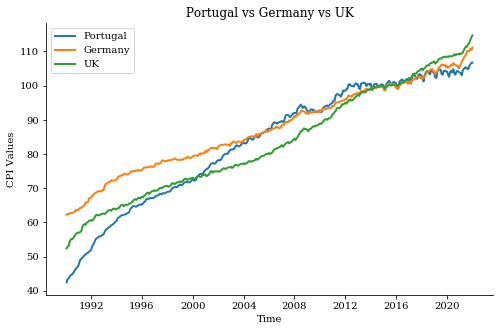

In [122]:
plt.rcParams['figure.figsize'] = (8, 5)

tsPlot(
	tsList,
	' Portugal vs Germany vs UK ',
	'Time', 'CPI Values',
	[ 'Portugal', 'Germany', 'UK' ]
)

In [123]:
multiTs = pd.concat(tsList, axis=1)
multiTs.columns = [ 'pt', 'ge', 'uk' ]

In [124]:
validationYears = 4
multiTsTrain = multiTs[multiTs.index[0]: multiTs.index[-13]]
multiTsVal = multiTs[multiTs.index[- (12 * (1 + validationYears))]: multiTs.index[-13]]
multiTsTest = multiTs[multiTs.index[-12]:]

In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(multiTsTrain)

multiTsTrain = pd.DataFrame(
	data=scaler.transform(multiTsTrain), 
	index=multiTsTrain.index, 
	columns=multiTsTrain.columns
)
multiTsVal = pd.DataFrame(
	data=scaler.transform(multiTsVal), 
	index=multiTsVal.index, 
	columns=multiTsVal.columns
)
multiTsTest = pd.DataFrame(
	data=scaler.transform(multiTsTest), 
	index=multiTsTest.index, 
	columns=multiTsTest.columns
)

Minimum RMSE is :0.003798206957678
Best Delay Combination:[[[0, 1, 12], [0, 1, 12]], [1, 2, 12]]


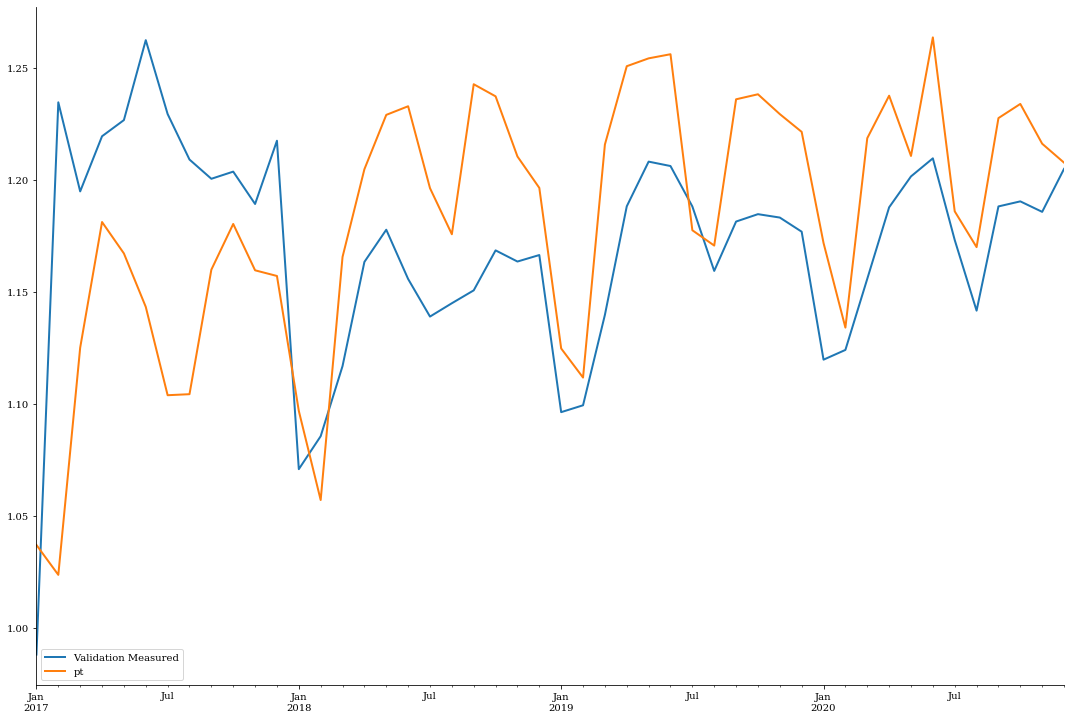

In [135]:
from sklearn.neural_network import MLPRegressor

delays=[[[[0,1],[0,1]],[1,2]],
      [[[0,1,12],[0,1,12]],[1,2,12]],
      [[[0,12],[0,12]],[1,12]]]

predicts=[]
rmses=[]
models=[]
for d in delays:
    maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
    
    #Generate input/output data
    data=timeseries_to_array(outData=multiTsTrain['pt'],inData=multiTsTrain[['ge','uk']],delayEndog=d[1],delayExog=d[0])
    input_train=data.iloc[:,0:-1].to_numpy()
    output_train=data.iloc[:,-1].to_numpy()
    dataTRTS=pd.Series(data=output_train,index=multiTsTrain['pt'].index[maxdel:],name='Training Data')
    
    #Validation data
    data_val=pd.DataFrame(pd.concat((multiTsTrain.iloc[multiTsTrain.shape[0]-maxdel:],multiTsVal)),columns=multiTsVal.columns)
    
    data=timeseries_to_array(outData=data_val['pt'],inData=data_val[['ge','uk']],delayEndog=d[1],delayExog=d[0])
    input_val=data.iloc[:,0:-1].to_numpy()
    output_val=data.iloc[:,-1].to_numpy()
    dataVLTS=pd.Series(data=output_val,index=data.index,name='Val Data')
    
    
    #Implement a MLP regressor
    regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                        hidden_layer_sizes=(10,)).fit(input_train, output_train)

    models.append(regr)
    #Evaluate Validation forecasting and error
    predictVLTS=pd.Series(data=regr.predict(input_val),index=dataVLTS.index,name='Validation Measured')
    predicts.append(predictVLTS)
    resTS=dataVLTS-predictVLTS
    resTS.name='Validation Forecasting'                       
    rmses.append((np.sum((resTS.to_numpy())**2))/resTS.size)
    
ix=np.where(rmses==np.min(rmses))[0][0]
print('Minimum RMSE is :'+str(rmses[ix]))
print('Best Delay Combination:'+str(delays[ix]))
#Lets plot best Val error
fig, axs=plt.subplots(1,figsize=(15,10))
fig.tight_layout()
predicts[ix].plot(ax=axs,legend=True)
multiTsVal['pt'].plot(ax=axs,legend=True)


#Testing performance
#Testing data preparation
d=delays[ix]
maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
data_test=pd.DataFrame(pd.concat((multiTsVal.iloc[multiTsVal.shape[0]-maxdel:],multiTsTest)),columns=multiTsTest.columns)
data=timeseries_to_array(outData=data_test['pt'],inData=data_test[['ge','uk']],delayEndog=d[1],delayExog=d[0])
input_test=data.iloc[:,0:-1].to_numpy()
output_test=data.iloc[:,-1].to_numpy()
dataTETS=pd.Series(data=output_test,index=data.index,name='Testing Measured')

Forecast RMSE=0.11526177506207316


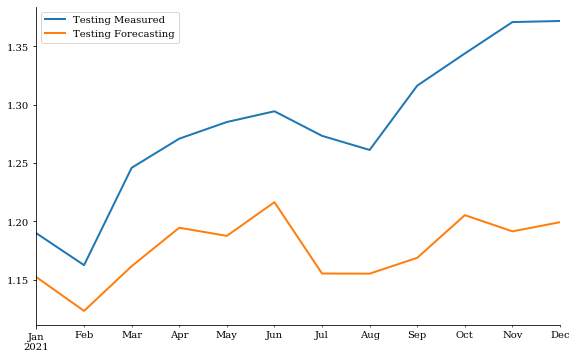

In [136]:
#Plot forecasting in testing
forecastTETS=pd.Series(data=models[ix].predict(input_test),index=dataTETS.index,name='Testing Forecasting')
fig, axs=plt.subplots(1,)
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

mlRMSE = str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size))
print("Forecast RMSE=" + mlRMSE)

In [134]:
print(f'''
RMSE
------------
MLP REGRESSOR: {mlRMSE}
SARIMA: {sarimaRMSE}
TES: {tesRMSE}
''')


RMSE
------------
MLP REGRESSOR: 0.11526177506207316
SARIMA: 1.5249322084167276
TES: 0.10588600748562389

